# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой Bootstrap.

Шаги для выбора локации:

В избранном регионе ищут месторождения, для каждого определяют значения признаков;
Строят модель и оценивают объём запасов;
Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
Прибыль равна суммарной прибыли отобранных месторождений.

Описание данных
Данные геологоразведки трёх регионов находятся в файлах:

geo_data_0.csv
geo_data_1.csv
geo_data_2.csv
id — уникальный идентификатор скважины;
f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
product — объём запасов в скважине (тыс. баррелей).

**Условия задачи:**
<br>Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
<br>При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
<br>Бюджет на разработку скважин в регионе — 10 млрд рублей.
<br>При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
<br>После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

**Импорт библиотеки**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

RANDOM_STATE = 42

## Загрузка и подготовка данных

In [2]:
from google.colab import files

# Загружаем сразу несколько файлов (можно выделить их при выборе)
uploaded = files.upload()

Saving geo_data_0.csv to geo_data_0.csv
Saving geo_data_1.csv to geo_data_1.csv
Saving geo_data_2.csv to geo_data_2.csv


In [3]:
pd.set_option('display.max_columns', None)

In [4]:
data0 = pd.read_csv('geo_data_0.csv')
data1 = pd.read_csv('geo_data_1.csv')
data2 = pd.read_csv('geo_data_2.csv')

In [5]:
display(data0.head())
print(data0.info())
display(data1.head())
print(data1.info())
display(data2.head())
print(data2.info())

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None


In [6]:
combined_df = pd.concat([data0, data1, data2], ignore_index=True)

duplicate_rows = combined_df[combined_df.duplicated(keep=False)]

print("Дубликаты в объединенном DataFrame:\n", duplicate_rows)

Дубликаты в объединенном DataFrame:
 Empty DataFrame
Columns: [id, f0, f1, f2, product]
Index: []


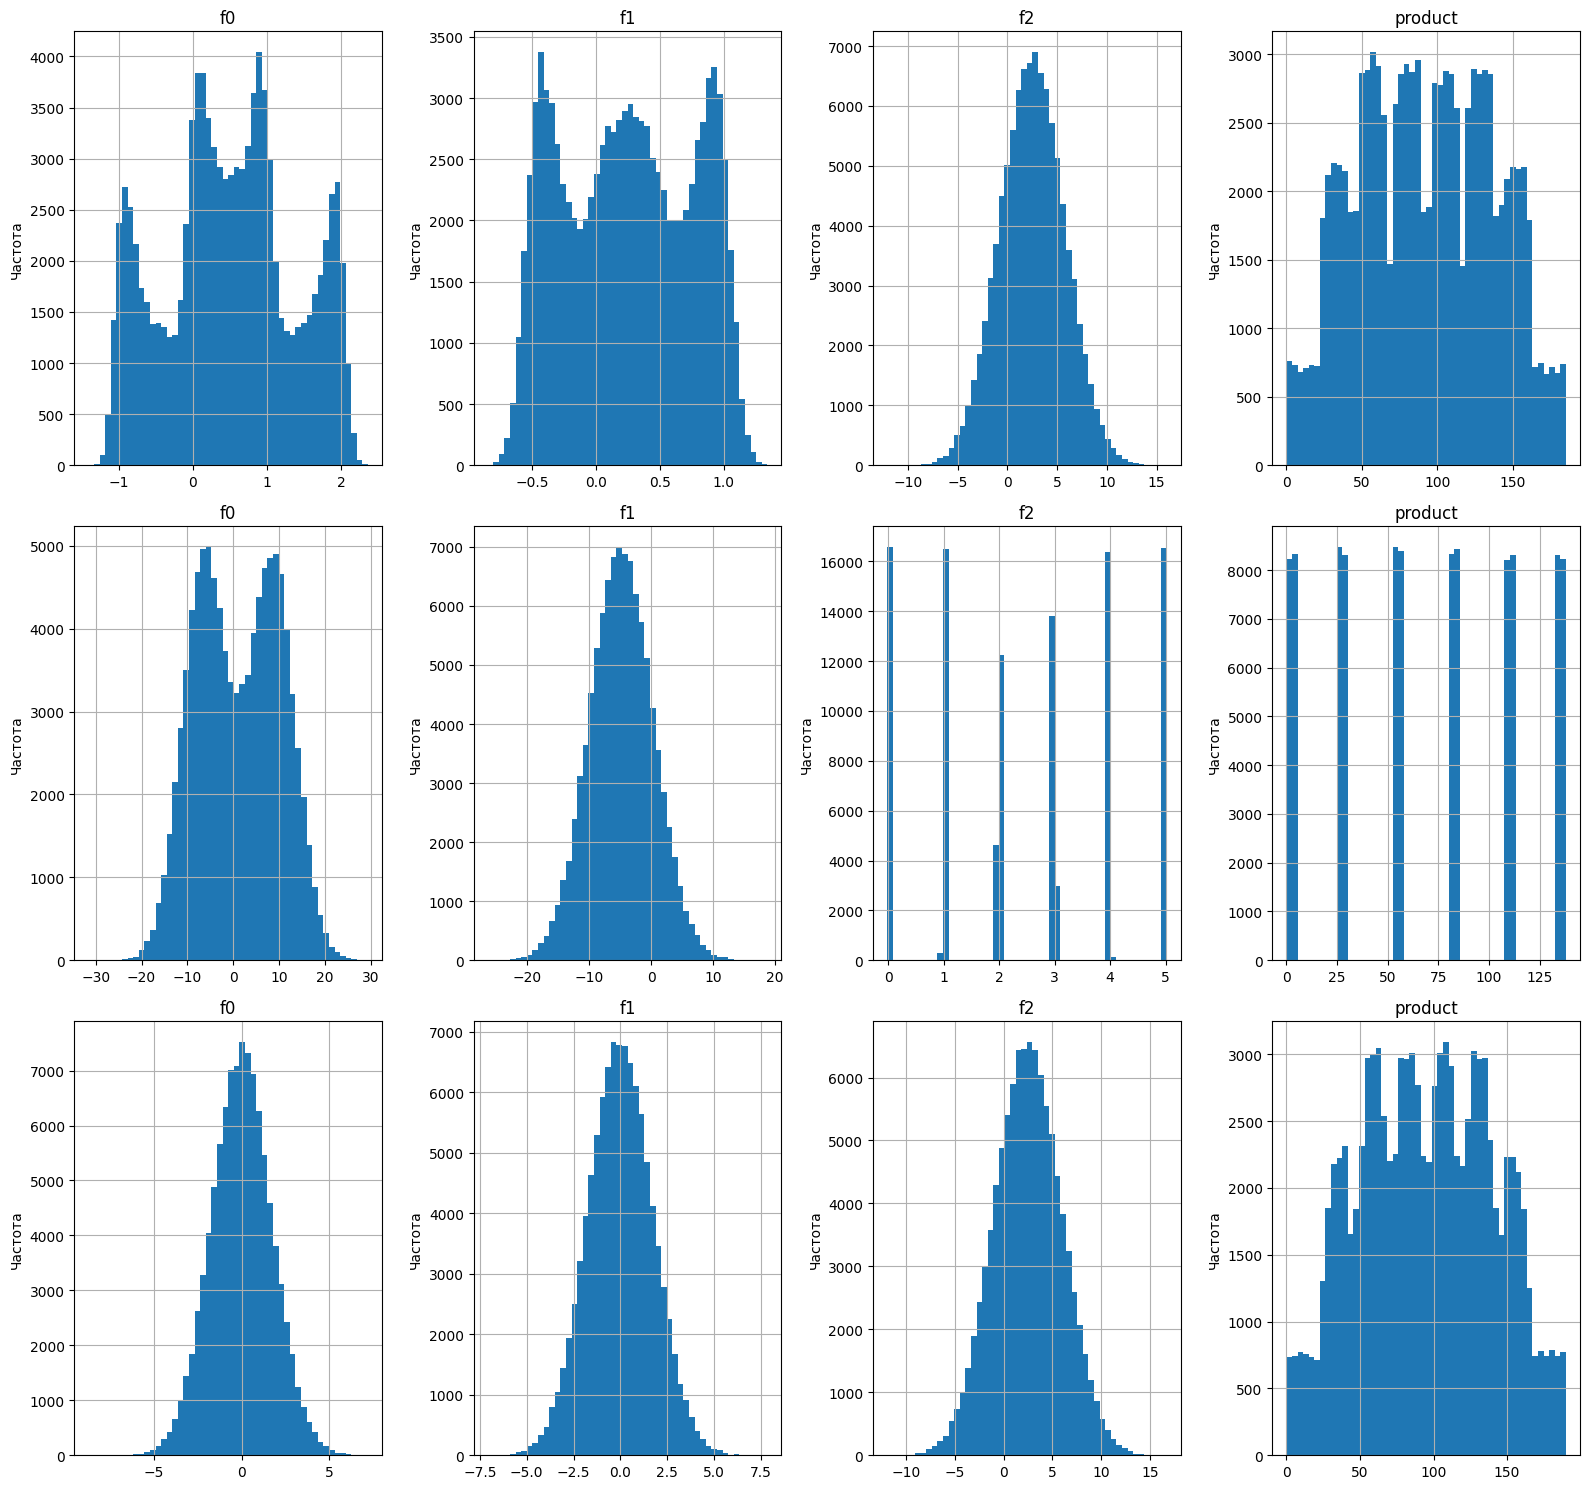

In [7]:
data_list = [data0, data1, data2]

fig, axes = plt.subplots(len(data_list), 4, figsize=(16, 15))

for i, df in enumerate(data_list):
    num_columns = df.select_dtypes(include=['number']).columns.tolist()

    for j, column in enumerate(num_columns):
        ax = axes[i, j]
        df[column].hist(ax=ax, bins=50)
        ax.set_title(column)
        ax.set_ylabel('Частота')

plt.tight_layout()
plt.show()

Графики data2 похожи на нормальное распределение, явных выбросов не видно.

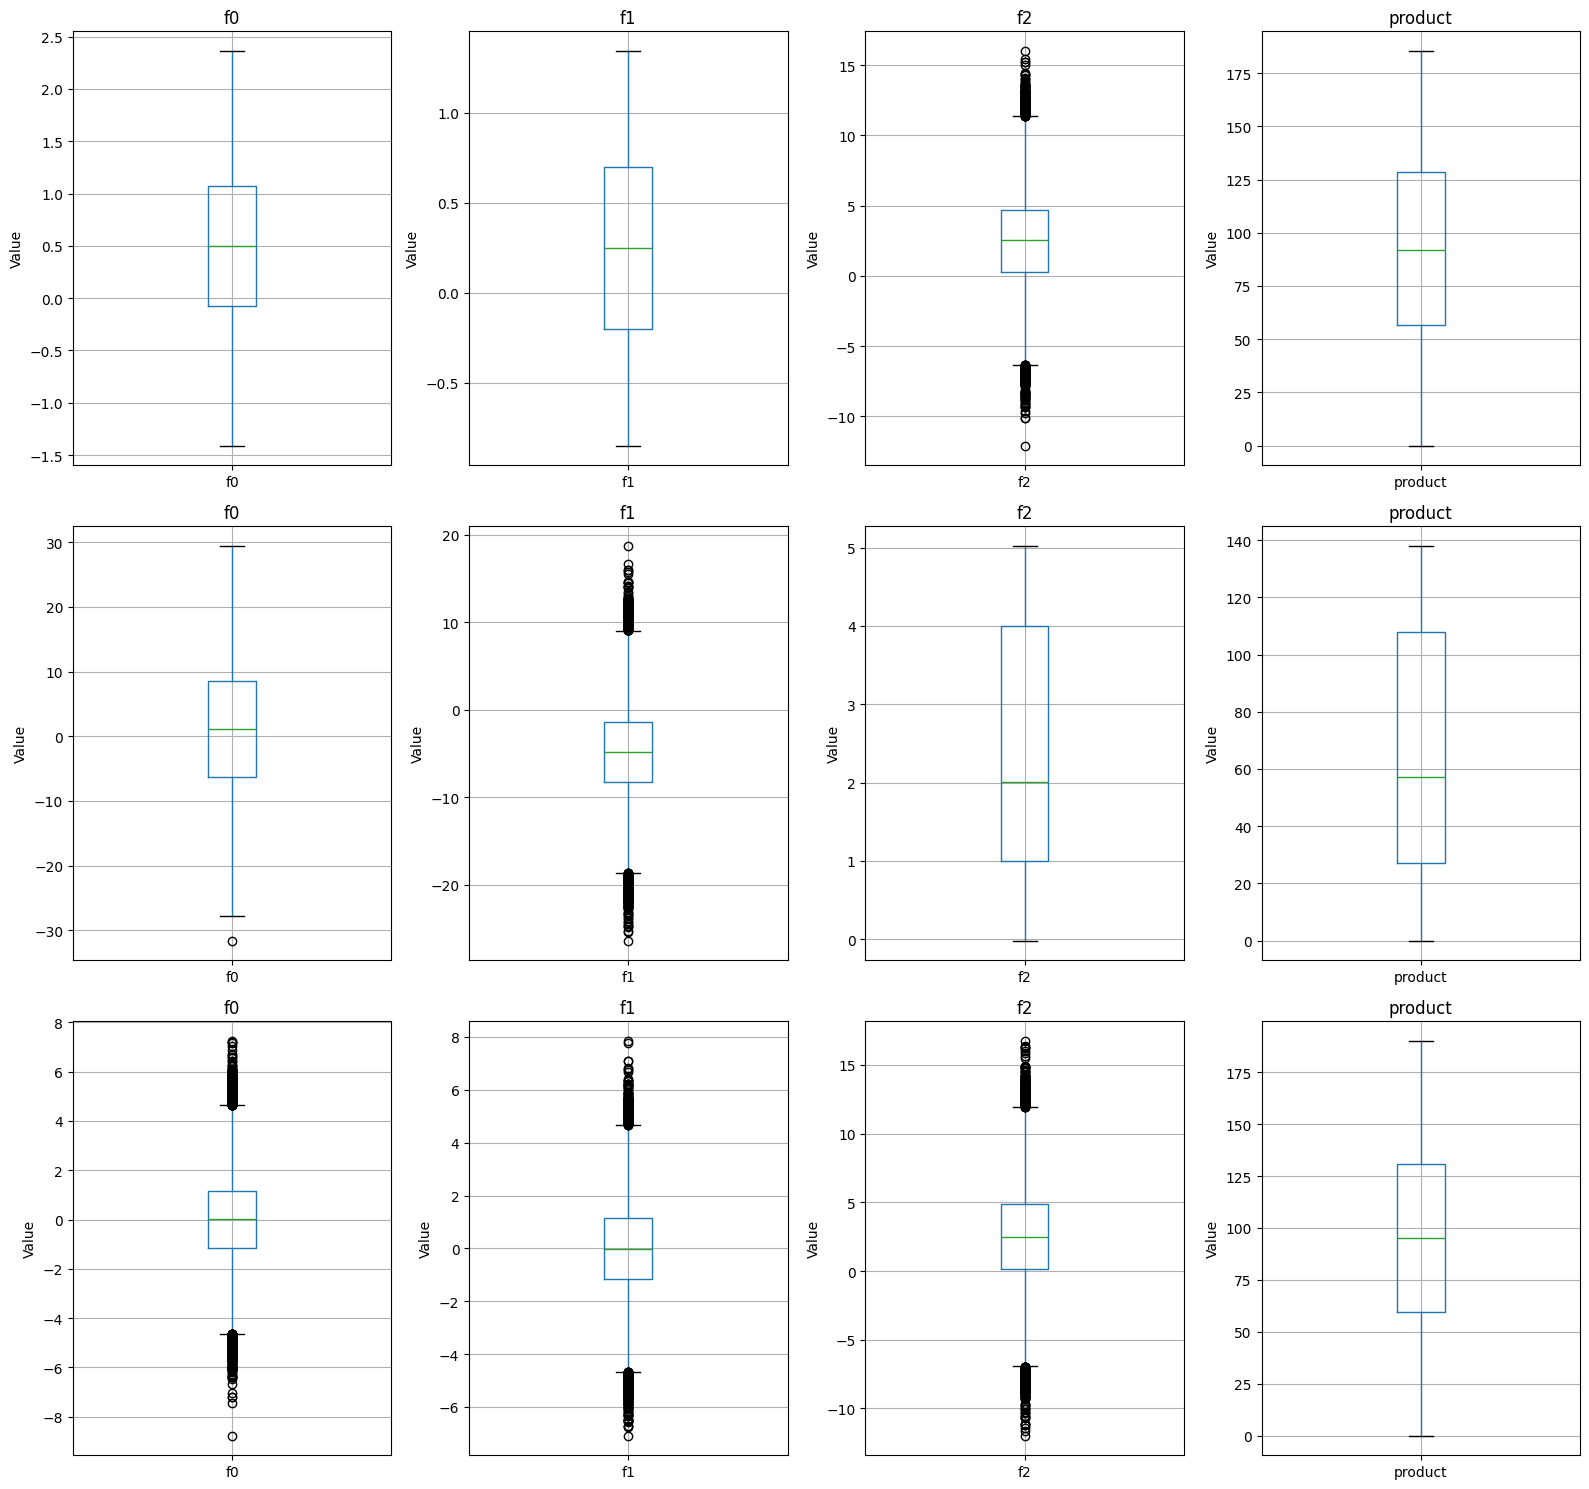

In [8]:
fig, axes = plt.subplots(len(data_list), 4, figsize=(16, 15))

for i, df in enumerate(data_list):
    num_columns = df.select_dtypes(include=['number']).columns.tolist()

    for j, column in enumerate(num_columns):
        ax = axes[i, j]  # Получаем нужную ось из созданного массива
        df.boxplot(column=column, ax=ax)
        ax.set_title(column)
        ax.set_ylabel('Value')

plt.tight_layout()  # Вызываем tight_layout после создания всех подграфиков
plt.show()

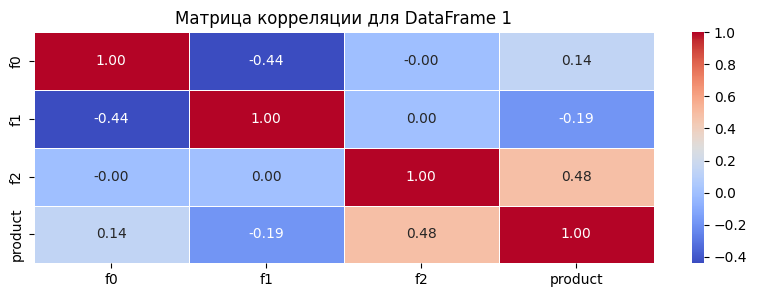

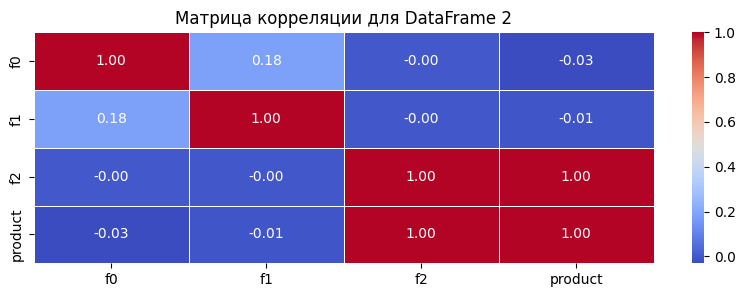

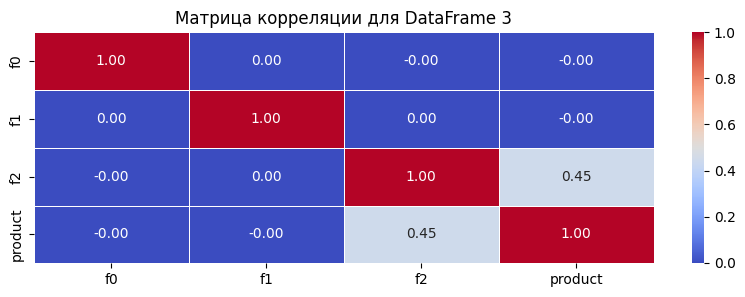

In [9]:
for i, df in enumerate(data_list):
    # Выбираем только числовые столбцы
    numerical_cols = df.select_dtypes(include=['number'])

    # Вычисляем матрицу корреляции
    correlation_matrix = numerical_cols.corr()

    # Создаем фигуру и оси
    plt.figure(figsize=(10, 3))  # Размер матрицы корреляции

    # Используем heatmap для визуализации матрицы корреляции
    sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5)

    # Задаем заголовок
    plt.title(f"Матрица корреляции для DataFrame {i+1}")

    # Отображаем график
    plt.show()

Были загружены 3df, дубликатов нету.

## Обучение и проверка модели

In [10]:
data0 = data0.set_index('id')
data1 = data1.set_index('id')
data2 = data2.set_index('id')

**Обучение data0**

In [11]:
X0 = data0.drop('product', axis = 1)
y0 = data0['product']
X0_train, X0_valid, y0_train, y0_valid = train_test_split(
        X0,
        y0,
        test_size=0.25,
        random_state=RANDOM_STATE
)

scaler0 = StandardScaler()
X0_train_scaler = scaler0.fit_transform(X0_train)
X0_valid_scaler = scaler0.transform(X0_valid)

model0 = LinearRegression()
model0.fit(X0_train_scaler, y0_train)
predict0 = model0.predict(X0_valid_scaler)

In [13]:
mean0 = predict0.mean()
rmse0 = np.sqrt(mean_squared_error(y0_valid, predict0))

print(f'Средний запас предсказанного сырья: {mean0}')
print(f'Значение метрики RMSE: {rmse0}')

Средний запас предсказанного сырья: 92.39879990657768
Значение метрики RMSE: 37.75660035026169


**Обучение data1**

In [14]:
X1 = data1.drop('product', axis = 1)
y1 = data1['product']
X1_train, X1_valid, y1_train, y1_valid = train_test_split(
        X1,
        y1,
        test_size=0.25,
        random_state=RANDOM_STATE
)

scaler1 = StandardScaler()
X1_train_scaler = scaler1.fit_transform(X1_train)
X1_valid_scaler = scaler1.transform(X1_valid)

model1 = LinearRegression()
model1.fit(X1_train_scaler, y1_train)
predict1 = model1.predict(X1_valid_scaler)

In [16]:
mean1 = predict1.mean()
rmse1 = np.sqrt(mean_squared_error(y1_valid, predict1))

print(f'Средний запас предсказанного сырья: {mean1}')
print(f'Значение метрики RMSE: {rmse1}')

Средний запас предсказанного сырья: 68.7128780391376
Значение метрики RMSE: 0.8902801001028845


**Обучение data2**

In [17]:
X2 = data2.drop('product', axis = 1)
y2 = data2['product']
X2_train, X2_valid, y2_train, y2_valid = train_test_split(
        X2,
        y2,
        test_size=0.25,
        random_state=RANDOM_STATE
)

scaler2 = StandardScaler()
X2_train_scaler = scaler2.fit_transform(X2_train)
X2_valid_scaler = scaler2.transform(X2_valid)

model2 = LinearRegression()
model2.fit(X2_train_scaler, y2_train)
predict2 = model2.predict(X2_valid_scaler)

In [18]:
mean2 = predict2.mean()
rmse2 = np.sqrt(mean_squared_error(y2_valid, predict2))

print(f'Средний запас предсказанного сырья: {mean2}')
print(f'Значение метрики RMSE: {rmse2}')

Средний запас предсказанного сырья: 94.77102387765939
Значение метрики RMSE: 40.145872311342174


In [19]:
data = [
    [mean0, rmse0],
    [mean1, rmse1],
    [mean2, rmse2]
]

df = pd.DataFrame(data, columns=['mean', 'rmse'])
print(df)

        mean       rmse
0  92.398800  37.756600
1  68.712878   0.890280
2  94.771024  40.145872


Видим, что в data2 самое высокое среднее, Но у data1 модель предсказывает с наименьшей ошибкой.

## Подготовка к расчёту прибыли

In [20]:
points = 500 #Всего точек
best_points = 200 #200 лучших точек
budget = 10**10 #Бюджет 10млрд
barrel = 450 #цена за 1 баррель
loss_probability = 0.025 #вероятность убытка

income_per_barrel = barrel*1000 #Доход с еденицы продукта, баррель * 1000

In [21]:
budget_one = budget/best_points #Деньги на скважину
print(budget_one)
volume = budget_one/income_per_barrel#Сколько нужно едениц продукта, чтобы покрыть расход
print(volume)

50000000.0
111.11111111111111


Каждая скважина должна иметь обьем не меньше 111.(1), что бы не уйти в минус.

## Расчёт прибыли и рисков

In [23]:
def profit(data, y_true, y_predict):
    data['predict'] = y_predict
    data['true'] = y_true
    data = data.sort_values(by = 'predict', ascending = False)
    data = data.head(best_points)
    profite = data['true'].sum()*income_per_barrel - budget
    return profite

In [24]:
state = np.random.RandomState(12345)

In [25]:
profit0 = []

for i in range(1000):
    subsample = X0_valid.sample(points, replace = True, random_state=state)
    profit0.append(profit(subsample, y0_valid, pd.DataFrame(predict0, index = X0_valid.index)))

print(f'Среднее значение прибыли: ', pd.Series(profit0).mean())

lower0 = pd.Series(profit0).quantile(0.025)
upper0 = pd.Series(profit0).quantile(0.975)
print(f'95%-доверительный интервал для региона data0 {lower0} до {upper0}')

print(f'Вероятность убытка: ', len([i for i in profit0 if i<0])/len(profit0)*100)

Среднее значение прибыли:  406278783.42441905
95%-доверительный интервал для региона data0 -117742136.49486831 до 911737050.7514055
Вероятность убытка:  6.7


In [26]:
profit1 = []

for i in range(1000):
    subsample = X1_valid.sample(points, replace = True, random_state=state)
    profit1.append(profit(subsample, y1_valid, pd.DataFrame(predict1, index = X1_valid.index)))

print(f'Среднее значение прибыли: ', pd.Series(profit1).mean())

lower1 = pd.Series(profit1).quantile(0.025)
upper1 = pd.Series(profit1).quantile(0.975)
print(f'95%-доверительный интервал для региона data0 {lower1} до {upper1}')

print(f'Вероятность убытка: ', len([i for i in profit1 if i<0])/len(profit1)*100)

Среднее значение прибыли:  441504277.5922549
95%-доверительный интервал для региона data0 35728489.280851334 до 828006639.0043902
Вероятность убытка:  1.6


In [27]:
profit2 = []

for i in range(1000):
    subsample = X2_valid.sample(points, replace = True, random_state=state)
    profit2.append(profit(subsample, y2_valid, pd.DataFrame(predict2, index = X2_valid.index)))

print(f'Среднее значение прибыли: ', pd.Series(profit2).mean())

lower2 = pd.Series(profit2).quantile(0.025)
upper2 = pd.Series(profit2).quantile(0.975)
print(f'95%-доверительный интервал для региона data0 {lower2} до {upper2}')

print(f'Вероятность убытка: ', len([i for i in profit2 if i<0])/len(profit2)*100)

Среднее значение прибыли:  385213195.91415244
95%-доверительный интервал для региона data0 -164785166.1090443 до 888206234.1976783
Вероятность убытка:  7.8


Результаты, для удобства

In [28]:
print('Регион data0')
print(f'Среднее значение прибыли: ', pd.Series(profit0).mean())
print(f'95%-доверительный интервал для региона data0 {lower0} до {upper0}')
print(f'Вероятность убытка: ', len([i for i in profit0 if i<0])/len(profit0)*100)

print('Регион data1')
print(f'Среднее значение прибыли: ', pd.Series(profit1).mean())
print(f'95%-доверительный интервал для региона data0 {lower1} до {upper1}')
print(f'Вероятность убытка: ', len([i for i in profit1 if i<0])/len(profit1)*100)

print('Регион data2')
print(f'Среднее значение прибыли: ', pd.Series(profit2).mean())
print(f'95%-доверительный интервал для региона data0 {lower2} до {upper2}')
print(f'Вероятность убытка: ', len([i for i in profit2 if i<0])/len(profit2)*100)

Регион data0
Среднее значение прибыли:  406278783.42441905
95%-доверительный интервал для региона data0 -117742136.49486831 до 911737050.7514055
Вероятность убытка:  6.7
Регион data1
Среднее значение прибыли:  441504277.5922549
95%-доверительный интервал для региона data0 35728489.280851334 до 828006639.0043902
Вероятность убытка:  1.6
Регион data2
Среднее значение прибыли:  385213195.91415244
95%-доверительный интервал для региона data0 -164785166.1090443 до 888206234.1976783
Вероятность убытка:  7.8


По заданию подходит регион data1, где вероятность убытка меньше 2.5%. Но данные выглядят странно, нужно уточнить, верные они или нет.